In [1]:
"""
SEE: https://github.com/sudoswap/lssvm/blob/main/src/LSSVMPair.sol
Events to query for are:
  1. SwapNFTInPair()
    - emitted by LSSVMPair.swapNFTsForToken()  (sell order)
    - has no data so need to look at Transfer event for volume
  2. SwapNFTOutPair()
    - emitted by LSSVMPair.swapTokenForAnyNFTs() (buy order)
    - has no data so need to look at Transfer event for volume
  3. SpotPriceUpdate(uint128 newSpotPrice)
    - emitted by LSSVMPair on spot price changes: use to track price changes

Look at all pair contracts for a particular NFT collection.
"""
# switch to sudo-ape wd first for ape project to work properly
import os
from pathlib import Path

if Path(*Path(os.getcwd()).parts[-2:]) == Path('sudo-ape/notebook'):
    os.chdir('..')

In [173]:
import numpy as np
import pandas as pd
import typing as tp

from ape import accounts, chain, Contract, networks, project
from math import ceil

In [4]:
networks.parse_network_choice('ethereum:mainnet:alchemy').__enter__()

<alchemy chain_id=1>

In [5]:
project.LSSVMPair

<LSSVMPair>

In [6]:
current_block = chain.blocks[-1].number
current_block

15646236

In [7]:
start_block = 14645816  # pair factory deployment
start_block

14645816

In [8]:
sudo_router = Contract("0x2B2e8cDA09bBA9660dCA5cB6233787738Ad68329")
sudo_router

<LSSVMRouter 0x2B2e8cDA09bBA9660dCA5cB6233787738Ad68329>

In [9]:
# look at xmons nft
sudo_pair_xmons = Contract("0x5caf332dca4e6c9e69d52f320c21e74845353db0")
sudo_pair_xmons

<LSSVMPair 0x5caF332DcA4e6C9E69d52F320c21e74845353db0>

In [10]:
# TRADE pool type
sudo_pair_xmons.poolType()

2

In [11]:
# look at xmons as the collection of choice
collection = project.ERC721.at(sudo_pair_xmons.nft())
collection

<ERC721 0x0427743DF720801825a5c82e0582B1E915E0F750>

In [12]:
collection.balanceOf(sudo_pair_xmons.address)

6

In [13]:
sudo_pair_xmons.SpotPriceUpdate

SpotPriceUpdate(uint128 newSpotPrice)

In [14]:
# start with top pool for collection first
# get start block from query_pairs IF query can't handle when start_block < contract creation block (it can, woot)
%time query_prices_xmons = sudo_pair_xmons.SpotPriceUpdate.query('*', start_block=start_block)
query_prices_xmons

INFO: Cache database has not been initialized
CPU times: user 34.3 s, sys: 5.39 s, total: 39.6 s
Wall time: 5min 11s


,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index
0,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9077669902912621000},0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d3...,15198846,0xd3b29ce639c43280c2a194b638e07a5e1541824210aa...,54,37
1,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 11577669902912621000},0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2e...,15199800,0x420f1997f04b486a8ed114b32337abb0f8722e82ef1f...,79,82
2,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 14077669902912621000},0x85212d1b00c2c505bda6b7a56d2b1f2a893646a0d55b...,15203036,0x0e89e72ff162aa1b1ec18cdad70825885d7c0884f425...,233,138
3,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 11577669902912621000},0x414ea41198833a399a68c9b66456047bc6dd349330d7...,15208415,0x36dce9b484abf8db83699dabf5d63cbca4b9f68cc7e2...,120,56
4,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9077669902912621000},0x28758b8d0ad21047a93b75089e210e0ca85f652842ef...,15218330,0x10112e7b56853191c7e46d36f0cca7431be567982f5c...,73,59
...,...,...,...,...,...,...,...,...
69,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 7330097087378640000},0x0f0c92c52a66419cf127e6d95465200306c53ba0f614...,15583837,0xac80c3a0f4b64fbcb0512cf4bcbfc67f77cb37a6bd36...,82,37
70,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9830097087378640000},0x3343670d15a90410dd5f689d9e6349e2a4343b7472e0...,15622000,0x76e15f58bc7e39a5e164277fa0b2bc2c6648f510adf7...,71,47
71,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 7330097087378640000},0xb11f71335fc38495ae8e9a3dac52bf8cf452f7b02c74...,15630253,0x9f61426c708fcd4622f26fd23b607c65a2cf08d3c4a2...,17,26
72,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9830097087378640000},0xa1759dc5b910d93a3464b9814e8010bddd25dafe66d7...,15641940,0xf85ed36d9edc63b7dc156d4a33256e254f8e4b02498a...,156,100


In [102]:
# utility functions to unfold event arguments into separate columns
def unfold_event_args(key: str, event_args: dict) -> tp.Any:
    return event_args[key]

def unfold(df: pd.DataFrame):
    if df.empty:
        return
    for key in df.iloc[-1]['event_arguments'].keys():
        df[key] = df['event_arguments'].apply(lambda ev: unfold_event_args(key, ev))

In [103]:
unfold(query_prices_xmons)

In [104]:
# only 70 price updates for this pool over the last 63 days since deployed (not much)
query_prices_xmons

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,newSpotPrice
0,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9077669902912621000},0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d3...,15198846,0xd3b29ce639c43280c2a194b638e07a5e1541824210aa...,54,37,9077669902912621000
1,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 11577669902912621000},0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2e...,15199800,0x420f1997f04b486a8ed114b32337abb0f8722e82ef1f...,79,82,11577669902912621000
2,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 14077669902912621000},0x85212d1b00c2c505bda6b7a56d2b1f2a893646a0d55b...,15203036,0x0e89e72ff162aa1b1ec18cdad70825885d7c0884f425...,233,138,14077669902912621000
3,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 11577669902912621000},0x414ea41198833a399a68c9b66456047bc6dd349330d7...,15208415,0x36dce9b484abf8db83699dabf5d63cbca4b9f68cc7e2...,120,56,11577669902912621000
4,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9077669902912621000},0x28758b8d0ad21047a93b75089e210e0ca85f652842ef...,15218330,0x10112e7b56853191c7e46d36f0cca7431be567982f5c...,73,59,9077669902912621000
...,...,...,...,...,...,...,...,...,...
69,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 7330097087378640000},0x0f0c92c52a66419cf127e6d95465200306c53ba0f614...,15583837,0xac80c3a0f4b64fbcb0512cf4bcbfc67f77cb37a6bd36...,82,37,7330097087378640000
70,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9830097087378640000},0x3343670d15a90410dd5f689d9e6349e2a4343b7472e0...,15622000,0x76e15f58bc7e39a5e164277fa0b2bc2c6648f510adf7...,71,47,9830097087378640000
71,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 7330097087378640000},0xb11f71335fc38495ae8e9a3dac52bf8cf452f7b02c74...,15630253,0x9f61426c708fcd4622f26fd23b607c65a2cf08d3c4a2...,17,26,7330097087378640000
72,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9830097087378640000},0xa1759dc5b910d93a3464b9814e8010bddd25dafe66d7...,15641940,0xf85ed36d9edc63b7dc156d4a33256e254f8e4b02498a...,156,100,9830097087378640000


<AxesSubplot: xlabel='block_number', ylabel='newSpotPrice'>

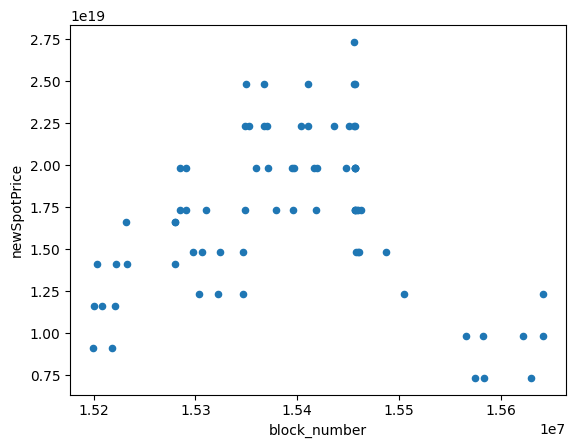

In [18]:
# initial plot for the top xmons pool
query_prices_xmons.plot(x='block_number', y='newSpotPrice', kind='scatter')

In [19]:
# load full pairs csv to get all collection
query_pairs = pd.read_csv('notebook/data/pairs_full.csv')

In [20]:
query_pairs

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,poolAddress,poolType,nft
0,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x08142348E6BBf233002b81047bc...,0xba75dd0b017667074a1ed080571fee06b3cea5444f25...,14650748,0xf63250e045af2d83fca5535fe3738deffd3c6f17f93b...,15,9,0x08142348E6BBf233002b81047bc2f27026af10A5,1,0x5Af0D9827E0c53E4799BB226655A1de152A425a5
1,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x518b7160990AD19dcfF0Ba028e2...,0x7e33fe2f08ee09a339b127c8658a892600637da3448d...,14652189,0x4b0de468eecdfea07b64168655f129d43d8e56f01f42...,41,37,0x518b7160990AD19dcfF0Ba028e245fA616b44F5E,1,0xCa7cA7BcC765F77339bE2d648BA53ce9c8a262bD
2,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x351E40e39ae7D0d60Dc283485bC...,0x230624db7d760f3ad189bdebb431ef74b6cd899855d6...,14652199,0x572e74e542e87e141a2176725d7b216133bd0d13dcf5...,150,117,0x351E40e39ae7D0d60Dc283485bC627891Ec1D00E,1,0x521f9C7505005CFA19A8E5786a9c3c9c9F5e6f42
3,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x0636a6Bd07dDBEA28a3cc63353e...,0xff03f1a4956f878f1bd42a6dfa2ec18165822cde3d15...,14652223,0x877d4993fe635aaaea71fa3c8bb8c705d67f86559c3e...,142,108,0x0636a6Bd07dDBEA28a3cc63353ea725e8cE509e2,1,0x0427743DF720801825a5c82e0582B1E915E0F750
4,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x866C5c02dC07EE37146c4874d70...,0x0c2b148a424bb8f25f32ca3ded2c87704cb73ab5b65b...,14662427,0x8f687e0ea159efeb37fd7e65ec00a008e6b96cc1b7ee...,171,149,0x866C5c02dC07EE37146c4874d704D3603bF5D950,1,0xD07e72b00431af84AD438CA995Fd9a7F0207542d
...,...,...,...,...,...,...,...,...,...,...,...
30990,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x9AAa20179145C9153a36Bbf71e2...,0x35feb962e106bfbd16bb949605d171bda649c015621d...,15561562,0x7fe005a4046800acc48f09ae4a0c92eea79f0cf0a38f...,481,265,0x9AAa20179145C9153a36Bbf71e2FF0c6eC2bed1f,1,0x1CEf785AA885836CeE4f53B6ACe83D187d819639
30991,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xf29EE6A9C566Fb837988a72bdaa...,0xf8451b200c08f1603db95f39140fb21d633f6119e9f4...,15561651,0x3c1e8ab50f8a8dcba3e5fae236eb5ec6640bf942d0e3...,146,92,0xf29EE6A9C566Fb837988a72bdaa5749564Dc8b69,2,0x8270FC3B2d23DE703b265b2ABE008883954fea8E
30992,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xCbb272D3c518386D1dd5a673698...,0x5eb463db486d91a5ee20d64f894d504b03820bcde553...,15561725,0x03a607aa73430521c37d30a177c1de30509b46a143fd...,110,39,0xCbb272D3c518386D1dd5a673698F02d1a0063D3c,1,0x1CEf785AA885836CeE4f53B6ACe83D187d819639
30993,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xC66Cfab72F2d43eb6Bb7058B2af...,0xe482845e9b8234d98b0e6ed1747b62bafc6ebc345dad...,15561734,0x6889adf6bf42faf501840a41858d7687860edc3e1138...,81,72,0xC66Cfab72F2d43eb6Bb7058B2af484A45eB2b9E9,1,0x1CEf785AA885836CeE4f53B6ACe83D187d819639


In [21]:
# focus on collection we care about
query_pairs_for_collection = query_pairs.copy()[query_pairs['nft'] == collection.address]

In [22]:
# wow, 81 pool pairs focused on xmons nft
query_pairs_for_collection

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,poolAddress,poolType,nft
3,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x0636a6Bd07dDBEA28a3cc63353e...,0xff03f1a4956f878f1bd42a6dfa2ec18165822cde3d15...,14652223,0x877d4993fe635aaaea71fa3c8bb8c705d67f86559c3e...,142,108,0x0636a6Bd07dDBEA28a3cc63353ea725e8cE509e2,1,0x0427743DF720801825a5c82e0582B1E915E0F750
27,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x3eaf9979b55E85Cf91980922eFD...,0x3a882f2571a30202e7b109f8075ff392f86c30d7f116...,14788468,0xc6d8dae849dd05ddec7508c673457238e18a8fe55a41...,138,48,0x3eaf9979b55E85Cf91980922eFDCae7cd818318D,1,0x0427743DF720801825a5c82e0582B1E915E0F750
162,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x23B5256CE9d8538EBd148051998...,0xad549e49c473d4ab475eb73b7990b60d7d460754c985...,15100682,0x7ecf57d813de8a1382c1d6b72e7400362ea1dab55b2f...,175,169,0x23B5256CE9d8538EBd14805199863E97397b1126,1,0x0427743DF720801825a5c82e0582B1E915E0F750
163,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xFEDF2F226C97A1106623C0a3c58...,0xdb41ebef7623358c2502c1ddb4ca539365af3dcbd6b8...,15101595,0x58ccd0444131c60fdc65cd31c3eb274bf3eab88f3856...,203,144,0xFEDF2F226C97A1106623C0a3c58BDDe197c44D38,1,0x0427743DF720801825a5c82e0582B1E915E0F750
164,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xb341b6a76478a69060c350B71b1...,0x458c500cf171ac4d3fd9fd3fa344d1ed24778beab03e...,15101624,0xfdafeac51272715769013f4227929f24dcf42a077667...,119,76,0xb341b6a76478a69060c350B71b13d283d5C6E8DA,1,0x0427743DF720801825a5c82e0582B1E915E0F750
...,...,...,...,...,...,...,...,...,...,...,...
29093,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xfE9B364E05ca9f2F5947C816184...,0xd34abc6259a53631fe00fbbc7b665705ff19c1694c37...,15477874,0xb9b56a4f6f973ac7ae2e4d84d03915e8f84f72d8e702...,620,250,0xfE9B364E05ca9f2F5947C816184A3f62F12CdFcc,0,0x0427743DF720801825a5c82e0582B1E915E0F750
29232,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xF6A90f5c9115903046aC5bEd89b...,0xb0cc3797ba8a86ffdd61f92b3fe384ea2d89174d33c8...,15486348,0xe916f4ae169538fe9a37ef4e4434475443dc35b60d5b...,244,103,0xF6A90f5c9115903046aC5bEd89b0A2B8FA9a23C1,1,0x0427743DF720801825a5c82e0582B1E915E0F750
29249,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x4eEDC301887673a2b7112f903BD...,0x73487512a29670525c5925b90b58af2486e8979e6b8e...,15486992,0xb315b7385732259e7c0bae69ee5d2001dfa66a6e9a9d...,96,27,0x4eEDC301887673a2b7112f903BD99344E3E44d0c,1,0x0427743DF720801825a5c82e0582B1E915E0F750
29268,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x1a9b5B2aEF0ef30054fEfb3Dbb6...,0xfe9844dc384913d3032eeb76deddab41d6f5e192bd66...,15488105,0x766413907814e8df5213905bc498e9108fa968f12025...,74,44,0x1a9b5B2aEF0ef30054fEfb3Dbb65Ec0E8d4F9DCD,1,0x0427743DF720801825a5c82e0582B1E915E0F750


In [23]:
# how many are of different pool types?
# interesting: only 3 trade pools. most LPs are trying to buy/sell NFT in a one sided pool (like a limit order)
print(f'# pairs for collection {collection.address} with poolType = {0}:', len(query_pairs_for_collection[query_pairs_for_collection['poolType'] == 0]))
print(f'# pairs for collection {collection.address} with poolType = {1}:', len(query_pairs_for_collection[query_pairs_for_collection['poolType'] == 1]))
print(f'# pairs for collection {collection.address} with poolType = {2}:', len(query_pairs_for_collection[query_pairs_for_collection['poolType'] == 2]))

# pairs for collection 0x0427743DF720801825a5c82e0582B1E915E0F750 with poolType = 0: 39
# pairs for collection 0x0427743DF720801825a5c82e0582B1E915E0F750 with poolType = 1: 39
# pairs for collection 0x0427743DF720801825a5c82e0582B1E915E0F750 with poolType = 2: 3


In [24]:
# NewPair events only give the pair address without any addition. Query
# for additional pool info from each pool contract at poolAddress in NewPair
def get_pair_specifics(key: str, x: pd.Series, is_method: bool = True) -> tp.Any:
    """
    Gets pair specific info from the LSSVMPair contract.
    """
    addr = x['poolAddress']
    pair = project.LSSVMPair.at(addr)
    try:
        val = getattr(pair, key)() if is_method else getattr(pair, key)
    except Exception:
        val = None
    return val

In [25]:
# get the current ETH (token) balances for each pool
%time query_balance_token = query_pairs_for_collection.apply(lambda x: get_pair_specifics('balance', x, False), axis=1)

CPU times: user 20.2 s, sys: 4.21 s, total: 24.4 s
Wall time: 34.9 s


In [26]:
# eth balances of xmons pools in wei terms
query_balance_token

3           0
27          0
162         0
163         0
164         0
         ... 
29093    1296
29232       0
29249       0
29268       0
29400       0
Length: 81, dtype: object

In [27]:
# pools with non-zero ETH balances ...
# 11/81 xmons collection pools have ETH balances
print('# of xmons pools with non-zero ETH balances:', len(query_balance_token[query_balance_token > 0]))
query_balance_token[query_balance_token > 0]

# of xmons pools with non-zero ETH balances: 11


814      46533257281553398300
3382          100000000000000
14120         100000000000000
16244         400000000000000
16328        1000000000000000
20240         399000000000000
21355           1000000000000
21390        1000000000000000
25084         110000000000000
28424         500000000000000
29093                    1296
dtype: object

In [28]:
# divide by number of decimals to put into ETH terms
query_balance_token[query_balance_token > 0] / 1e18

814      46.533257
3382        0.0001
14120       0.0001
16244       0.0004
16328        0.001
20240     0.000399
21355     0.000001
21390        0.001
25084      0.00011
28424       0.0005
29093          0.0
dtype: object

In [29]:
# NewPair events only give the pair address without any addition. Query
# for additional pool info from each pool contract at poolAddress in NewPair
def get_nft_balance(nft_addr: str, x: pd.Series) -> int:
    """
    Gets pair specific info from the LSSVMPair contract.
    """
    pool_addr = x['poolAddress']
    nft = project.ERC721.at(nft_addr)
    return nft.balanceOf(pool_addr)

In [30]:
# get the current NFT balances for each pool
%time query_balance_nft = query_pairs_for_collection.apply(lambda x: get_nft_balance(collection.address, x), axis=1)

CPU times: user 22.8 s, sys: 4.41 s, total: 27.2 s
Wall time: 56 s


In [31]:
query_balance_nft

3        0
27       0
162      6
163      0
164      1
        ..
29093    0
29232    0
29249    0
29268    0
29400    0
Length: 81, dtype: int64

In [32]:
# add both balance columsn to collection pairs df
query_pairs_for_collection['balance_token'] = query_balance_token / 1e18
query_pairs_for_collection['balance_nft'] = query_balance_nft

In [33]:
query_pairs_for_collection

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,poolAddress,poolType,nft,balance_token,balance_nft
3,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x0636a6Bd07dDBEA28a3cc63353e...,0xff03f1a4956f878f1bd42a6dfa2ec18165822cde3d15...,14652223,0x877d4993fe635aaaea71fa3c8bb8c705d67f86559c3e...,142,108,0x0636a6Bd07dDBEA28a3cc63353ea725e8cE509e2,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,0
27,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x3eaf9979b55E85Cf91980922eFD...,0x3a882f2571a30202e7b109f8075ff392f86c30d7f116...,14788468,0xc6d8dae849dd05ddec7508c673457238e18a8fe55a41...,138,48,0x3eaf9979b55E85Cf91980922eFDCae7cd818318D,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,0
162,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x23B5256CE9d8538EBd148051998...,0xad549e49c473d4ab475eb73b7990b60d7d460754c985...,15100682,0x7ecf57d813de8a1382c1d6b72e7400362ea1dab55b2f...,175,169,0x23B5256CE9d8538EBd14805199863E97397b1126,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,6
163,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xFEDF2F226C97A1106623C0a3c58...,0xdb41ebef7623358c2502c1ddb4ca539365af3dcbd6b8...,15101595,0x58ccd0444131c60fdc65cd31c3eb274bf3eab88f3856...,203,144,0xFEDF2F226C97A1106623C0a3c58BDDe197c44D38,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,0
164,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xb341b6a76478a69060c350B71b1...,0x458c500cf171ac4d3fd9fd3fa344d1ed24778beab03e...,15101624,0xfdafeac51272715769013f4227929f24dcf42a077667...,119,76,0xb341b6a76478a69060c350B71b13d283d5C6E8DA,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29093,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xfE9B364E05ca9f2F5947C816184...,0xd34abc6259a53631fe00fbbc7b665705ff19c1694c37...,15477874,0xb9b56a4f6f973ac7ae2e4d84d03915e8f84f72d8e702...,620,250,0xfE9B364E05ca9f2F5947C816184A3f62F12CdFcc,0,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,0
29232,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xF6A90f5c9115903046aC5bEd89b...,0xb0cc3797ba8a86ffdd61f92b3fe384ea2d89174d33c8...,15486348,0xe916f4ae169538fe9a37ef4e4434475443dc35b60d5b...,244,103,0xF6A90f5c9115903046aC5bEd89b0A2B8FA9a23C1,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,0
29249,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x4eEDC301887673a2b7112f903BD...,0x73487512a29670525c5925b90b58af2486e8979e6b8e...,15486992,0xb315b7385732259e7c0bae69ee5d2001dfa66a6e9a9d...,96,27,0x4eEDC301887673a2b7112f903BD99344E3E44d0c,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,0
29268,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x1a9b5B2aEF0ef30054fEfb3Dbb6...,0xfe9844dc384913d3032eeb76deddab41d6f5e192bd66...,15488105,0x766413907814e8df5213905bc498e9108fa968f12025...,74,44,0x1a9b5B2aEF0ef30054fEfb3Dbb65Ec0E8d4F9DCD,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,0


In [34]:
# filter out the zero pools
min_token_size = 0.01
print('# of pairs with balances > min:', len(query_pairs_for_collection[(query_pairs_for_collection['balance_token'] > min_token_size) | (query_pairs_for_collection['balance_nft'] > 0)]))
query_pairs_for_collection_w_balance = query_pairs_for_collection[(query_pairs_for_collection['balance_token'] > min_token_size) | (query_pairs_for_collection['balance_nft'] > 0)]
query_pairs_for_collection_w_balance

# of pairs with balances > min: 10


,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,poolAddress,poolType,nft,balance_token,balance_nft
162,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x23B5256CE9d8538EBd148051998...,0xad549e49c473d4ab475eb73b7990b60d7d460754c985...,15100682,0x7ecf57d813de8a1382c1d6b72e7400362ea1dab55b2f...,175,169,0x23B5256CE9d8538EBd14805199863E97397b1126,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,6
164,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xb341b6a76478a69060c350B71b1...,0x458c500cf171ac4d3fd9fd3fa344d1ed24778beab03e...,15101624,0xfdafeac51272715769013f4227929f24dcf42a077667...,119,76,0xb341b6a76478a69060c350B71b13d283d5C6E8DA,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,1
814,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x5caF332DcA4e6C9E69d52F320c2...,0x7e866076d6ba9b1ca2bbd8574c953bb369d84b0915a9...,15181476,0x105a983c12fd2fb13f281eb94077d5d0481832521a5b...,228,116,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,2,0x0427743DF720801825a5c82e0582B1E915E0F750,46.533257,6
10844,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x1544F99043acBC1ceffE2Bc03BB...,0xd5f1cfb2ee8db3805c278459b990284216a6513cf45d...,15346659,0x6b12e183b541efa775abc8d090d8e66d9ba5f8c5800c...,178,93,0x1544F99043acBC1ceffE2Bc03BBdC6A9017196A1,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,3
12013,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x4c19B043e4e3fEcEd7D7734928d...,0x7e9ec12d7287486c6f77c805a13d9ab8d5a10808e311...,15353371,0xb9270e7536ed21f4a86f2c0d98050604ec1c2665bf9c...,103,182,0x4c19B043e4e3fEcEd7D7734928d205aCB84885cf,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,1
19092,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xBa633d5F380aE1090D256B79109...,0x253b2cc526dfd34a1fb7704140503291308497b844d4...,15395034,0xc3bee0ef779705ac0546a8df8d23c11eb73eb40cbf29...,101,42,0xBa633d5F380aE1090D256B79109A850F11870d0b,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,1
25889,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xf33893376FCC3709bEDb6acCceD...,0x968d98444a53a2fe2b906b78b717cc2b3fdc3d5b22ed...,15430949,0x20edf13e97bb34b7ad6a3fafb0ee011c8ca10144318e...,128,88,0xf33893376FCC3709bEDb6acCceDDc9618d65DB6F,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,1
28337,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x980147F6d452cb3642bA4a97f19...,0x6bfc9cc1f433b4352837fa62776527814c9e40048b75...,15456982,0x6d88dd9c4548d42014c42bac3a5f9ac3bcc5ae3e8767...,172,120,0x980147F6d452cb3642bA4a97f1966bd92D326B23,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,2
28392,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x2C841D58064Cb092bf72a846382...,0x21d39004feba2cf25e4ff2691201cab54d21273c2d53...,15457772,0xe7b788a38e899760dcd88eec5822e9143e3b94c32da2...,323,156,0x2C841D58064Cb092bf72a8463828cEA54FAb91BA,2,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,3
28776,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x4063D73a22b9f660F24bab57452...,0x8e9a99ba6b548e52e7ce0c0a7db6a8272c8e441bacdd...,15467204,0x4e202dd8ea2f719be9a3283ff3773c5a3d05d4e9c2a3...,41,37,0x4063D73a22b9f660F24bab574522212D8d930b9d,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,2


In [35]:
# TODO: look at the price history for these 10 pools
%time sudo_pair_xmons.SpotPriceUpdate.query('*', start_block=start_block)

CPU times: user 34.1 s, sys: 5.28 s, total: 39.3 s
Wall time: 5min 15s


,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index
0,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9077669902912621000},0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d3...,15198846,0xd3b29ce639c43280c2a194b638e07a5e1541824210aa...,54,37
1,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 11577669902912621000},0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2e...,15199800,0x420f1997f04b486a8ed114b32337abb0f8722e82ef1f...,79,82
2,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 14077669902912621000},0x85212d1b00c2c505bda6b7a56d2b1f2a893646a0d55b...,15203036,0x0e89e72ff162aa1b1ec18cdad70825885d7c0884f425...,233,138
3,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 11577669902912621000},0x414ea41198833a399a68c9b66456047bc6dd349330d7...,15208415,0x36dce9b484abf8db83699dabf5d63cbca4b9f68cc7e2...,120,56
4,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9077669902912621000},0x28758b8d0ad21047a93b75089e210e0ca85f652842ef...,15218330,0x10112e7b56853191c7e46d36f0cca7431be567982f5c...,73,59
...,...,...,...,...,...,...,...,...
69,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 7330097087378640000},0x0f0c92c52a66419cf127e6d95465200306c53ba0f614...,15583837,0xac80c3a0f4b64fbcb0512cf4bcbfc67f77cb37a6bd36...,82,37
70,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9830097087378640000},0x3343670d15a90410dd5f689d9e6349e2a4343b7472e0...,15622000,0x76e15f58bc7e39a5e164277fa0b2bc2c6648f510adf7...,71,47
71,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 7330097087378640000},0xb11f71335fc38495ae8e9a3dac52bf8cf452f7b02c74...,15630253,0x9f61426c708fcd4622f26fd23b607c65a2cf08d3c4a2...,17,26
72,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9830097087378640000},0xa1759dc5b910d93a3464b9814e8010bddd25dafe66d7...,15641940,0xf85ed36d9edc63b7dc156d4a33256e254f8e4b02498a...,156,100


In [36]:
# NOTE: an example iteration to make into a loop over pool addresses
pair = project.LSSVMPair.at(query_pairs_for_collection_w_balance.iloc[2].poolAddress)
%time query_prices = pair.SpotPriceUpdate.query('*', start_block=start_block)

CPU times: user 34.5 s, sys: 5.44 s, total: 40 s
Wall time: 5min 24s


In [37]:
if len(query_prices) > 0:
    # unfold the event arguments
    unfold(query_prices)

    # prep for smoothing by setting index to block number (choose last swap in block to represent price at block)
    query_prices_filtered = query_prices.filter(['block_number', 'newSpotPrice']).drop_duplicates('block_number', keep='last')
    query_prices_filtered = query_prices_filtered.set_index('block_number')

    # see what we got
    query_prices_filtered

In [38]:
query_prices_filtered['price'] = query_prices_filtered['newSpotPrice'] / 1e18
query_prices_filtered = query_prices_filtered.drop('newSpotPrice', axis=1)

In [39]:
query_prices_filtered

,price
block_number,
15198846,9.07767
15199800,11.57767
15203036,14.07767
15208415,11.57767
15218330,9.07767
...,...
15583837,7.330097
15622000,9.830097
15630253,7.330097


<AxesSubplot: xlabel='block_number'>

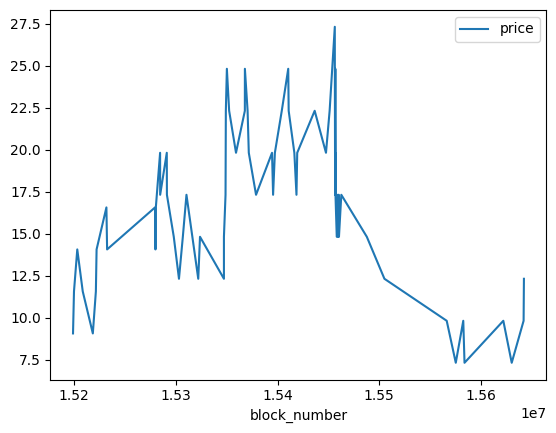

In [40]:
query_prices_filtered.plot(y='price')

In [41]:
# make block range timesteps uniform to build candles
# reindex by block number (1 block steps) and ffill price values 
new_index = range(start_block, current_block+1)
query_prices_filtered_reindexed = query_prices_filtered.reindex(new_index, method='ffill', fill_value=0)

In [42]:
query_prices_filtered_reindexed

,price
block_number,
14645816,0
14645817,0
14645818,0
14645819,0
14645820,0
...,...
15646232,12.330097
15646233,12.330097
15646234,12.330097


<AxesSubplot: xlabel='block_number'>

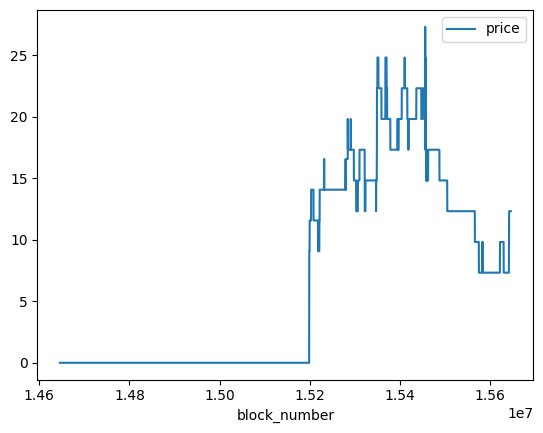

In [43]:
# WOOT. way better. looking like candles now
query_prices_filtered_reindexed.plot(y='price')

In [44]:
# make block range timesteps uniform to build candles
new_index = range(start_block, current_block+1)

In [45]:
len(new_index)

1000421

In [85]:
# function to be applied to each pair in query pairs for collection
def get_pool_prices(x: pd.Series) -> pd.DataFrame:
    pool_addr = x['poolAddress']
    pair = project.LSSVMPair.at(pool_addr)
    print('pair:', pair)
   
    # query for prices
    return pair.SpotPriceUpdate.query('*', start_block=start_block)

In [225]:
query_pairs_for_collection_w_balance

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,poolAddress,poolType,nft,balance_token,balance_nft
162,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x23B5256CE9d8538EBd148051998...,0xad549e49c473d4ab475eb73b7990b60d7d460754c985...,15100682,0x7ecf57d813de8a1382c1d6b72e7400362ea1dab55b2f...,175,169,0x23B5256CE9d8538EBd14805199863E97397b1126,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,6
164,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xb341b6a76478a69060c350B71b1...,0x458c500cf171ac4d3fd9fd3fa344d1ed24778beab03e...,15101624,0xfdafeac51272715769013f4227929f24dcf42a077667...,119,76,0xb341b6a76478a69060c350B71b13d283d5C6E8DA,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,1
814,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x5caF332DcA4e6C9E69d52F320c2...,0x7e866076d6ba9b1ca2bbd8574c953bb369d84b0915a9...,15181476,0x105a983c12fd2fb13f281eb94077d5d0481832521a5b...,228,116,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,2,0x0427743DF720801825a5c82e0582B1E915E0F750,46.533257,6
10844,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x1544F99043acBC1ceffE2Bc03BB...,0xd5f1cfb2ee8db3805c278459b990284216a6513cf45d...,15346659,0x6b12e183b541efa775abc8d090d8e66d9ba5f8c5800c...,178,93,0x1544F99043acBC1ceffE2Bc03BBdC6A9017196A1,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,3
12013,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x4c19B043e4e3fEcEd7D7734928d...,0x7e9ec12d7287486c6f77c805a13d9ab8d5a10808e311...,15353371,0xb9270e7536ed21f4a86f2c0d98050604ec1c2665bf9c...,103,182,0x4c19B043e4e3fEcEd7D7734928d205aCB84885cf,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,1
19092,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xBa633d5F380aE1090D256B79109...,0x253b2cc526dfd34a1fb7704140503291308497b844d4...,15395034,0xc3bee0ef779705ac0546a8df8d23c11eb73eb40cbf29...,101,42,0xBa633d5F380aE1090D256B79109A850F11870d0b,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,1
25889,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xf33893376FCC3709bEDb6acCceD...,0x968d98444a53a2fe2b906b78b717cc2b3fdc3d5b22ed...,15430949,0x20edf13e97bb34b7ad6a3fafb0ee011c8ca10144318e...,128,88,0xf33893376FCC3709bEDb6acCceDDc9618d65DB6F,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,1
28337,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x980147F6d452cb3642bA4a97f19...,0x6bfc9cc1f433b4352837fa62776527814c9e40048b75...,15456982,0x6d88dd9c4548d42014c42bac3a5f9ac3bcc5ae3e8767...,172,120,0x980147F6d452cb3642bA4a97f1966bd92D326B23,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,2
28392,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x2C841D58064Cb092bf72a846382...,0x21d39004feba2cf25e4ff2691201cab54d21273c2d53...,15457772,0xe7b788a38e899760dcd88eec5822e9143e3b94c32da2...,323,156,0x2C841D58064Cb092bf72a8463828cEA54FAb91BA,2,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,3
28776,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x4063D73a22b9f660F24bab57452...,0x8e9a99ba6b548e52e7ce0c0a7db6a8272c8e441bacdd...,15467204,0x4e202dd8ea2f719be9a3283ff3773c5a3d05d4e9c2a3...,41,37,0x4063D73a22b9f660F24bab574522212D8d930b9d,1,0x0427743DF720801825a5c82e0582B1E915E0F750,0.0,2


In [176]:
chunk_size = 4
num_chunks = ceil(len(query_pairs_for_collection_w_balance) / chunk_size)
chunk_idx = 0
query_prices_by_collection_chunked = []

In [196]:
# apply get pool prices to each pool in query pairs by collection
# TODO: apply to all pairs for collection (not just w balance now)
# chunk it ...
if chunk_idx < num_chunks:
    %time query_prices_by_collection_chunked.append(query_pairs_for_collection_w_balance[chunk_idx*chunk_size:(chunk_idx+1)*chunk_size].apply(get_pool_prices, axis=1))
    chunk_idx += 1

In [197]:
chunk_idx

3

In [226]:
# unchunk query prices by collection
query_prices_by_collection = pd.Series([ df for chunk in query_prices_by_collection_chunked for df in chunk ], index=query_pairs_for_collection_w_balance.index)

In [231]:
# apply unfold to each query df
query_prices_by_collection.apply(unfold)

162      None
164      None
814      None
10844    None
12013    None
19092    None
25889    None
28337    None
28392    None
28776    None
dtype: object

In [255]:
query_prices_by_collection.iloc[5]

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,newSpotPrice
0,SpotPriceUpdate,0xBa633d5F380aE1090D256B79109A850F11870d0b,{'newSpotPrice': 127363184079602010000},0xda249eda973b35f9abc3e31c578894218633402072c6...,15510600,0x4b3196c439d5da74585edead787118a215efd7645202...,51,50,127363184079602010000


In [265]:
# build up a new dataframe for price timeseries over each pool
query_price_timeseries = pd.DataFrame()

# NOTE: value is a df with newSpotPrice event emissions
for index, value in query_prices_by_collection.items():
    s = pd.Series(data=np.zeros(len(new_index)), index=new_index)
    if not value.empty:
        s = value.set_index('block_number').filter(['block_number', 'newSpotPrice'])['newSpotPrice']
        s = s.reindex(new_index, method='ffill', fill_value=0)  # reindex for even blocks across pools
        s = s / 1e18  # normalize to ETH terms (instead of wei)

    query_price_timeseries[index] = s

In [266]:
query_price_timeseries

,162,164,814,10844,12013,19092,25889,28337,28392,28776
14645816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
14645817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
14645818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
14645819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
14645820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...
15646232,0.0,48.551244,12.330097,0.0,0.0,127.363184,0.0,19.402985,15.40835,15.024876
15646233,0.0,48.551244,12.330097,0.0,0.0,127.363184,0.0,19.402985,15.40835,15.024876
15646234,0.0,48.551244,12.330097,0.0,0.0,127.363184,0.0,19.402985,15.40835,15.024876
15646235,0.0,48.551244,12.330097,0.0,0.0,127.363184,0.0,19.402985,15.40835,15.024876


In [267]:
# reference query_pairs to get the pool address for these price time series plots
query_pairs_for_collection_w_balance['poolAddress']

162      0x23B5256CE9d8538EBd14805199863E97397b1126
164      0xb341b6a76478a69060c350B71b13d283d5C6E8DA
814      0x5caF332DcA4e6C9E69d52F320c21e74845353db0
10844    0x1544F99043acBC1ceffE2Bc03BBdC6A9017196A1
12013    0x4c19B043e4e3fEcEd7D7734928d205aCB84885cf
19092    0xBa633d5F380aE1090D256B79109A850F11870d0b
25889    0xf33893376FCC3709bEDb6acCceDDc9618d65DB6F
28337    0x980147F6d452cb3642bA4a97f1966bd92D326B23
28392    0x2C841D58064Cb092bf72a8463828cEA54FAb91BA
28776    0x4063D73a22b9f660F24bab574522212D8d930b9d
Name: poolAddress, dtype: object

<AxesSubplot: >

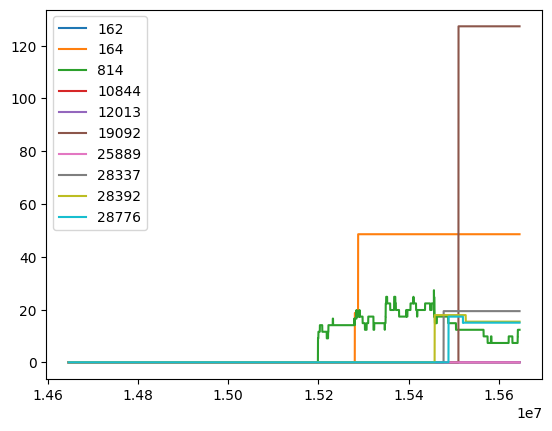

In [268]:
query_price_timeseries.plot()